## Cross Correlogram plots 

In [26]:
import numpy as np
import glob 
import pickle 
import matplotlib.pyplot as plt 
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## Method 1 + 2  -- averaging the histograms  -- counting maximum correlations 


* first compute unit-to-unit correlograms ,
* normalize the correlograms by parent-unit spikes. 
* correct the correlations ( by subtracting out the base correlation )
* filter units exceeding thresholds ( 3 std. )
* plot the histogram of locations with maximum correlation 
* and plot average correlations grouped by area pairs. 



### All area pairs 

In [27]:
from collections import Counter 
T = 100
W = 50 



temp = [
     [
        ['v1', 'hippo'], 
        '../../V1HPC/output__stimuli_0/DI_values/V1HPC_spks_CQuinn_pre/0/500_1500/lasso_0.5/',
        '../../V1HPC/output__stimuli_0/DI_values/V1HPC_spks_CQuinn_post/0/500_1500/lasso_0.5/'
    ],
    [
        ['V1', 'LP'], 
        '../../V1LP/output__stimuli_0/DI_values/V1LP_spks_CQuinn_pre/0/500_1500/lasso_0.5/',
        '../../V1LP/output__stimuli_0/DI_values/V1LP_spks_CQuinn_post/0/500_1500/lasso_0.5/'
    ], 
    [
        ['V1', 'LGN'], 
        '../../V1LGN/output__stimuli_0/DI_values/V1LGN_spks_CQuinn_pre/0/500_1500/lasso_0.5/',
        '../../V1LGN/output__stimuli_0/DI_values/V1LGN_spks_CQuinn_post/0/500_1500/lasso_0.5/'
    ],
    [
        ['V1', 'RSC'], 
        '../../V1RSC/output__stimuli_0/DI_values/V1RSC_spks_CQuinn_pre/0/500_1500/lasso_0.5/',
        '../../V1RSC/output__stimuli_0/DI_values/V1RSC_spks_CQuinn_post/0/500_1500/lasso_0.5/'
        ]
]



In [31]:
def plot_result(title, areas, a2a, a2a_peaks, a2a_count, total_pairs, min_val, max_val, min_val_pk, max_val_pk):

    figure, axes = plt.subplots(len(areas), len(areas), figsize=(15, 15))
    for i, a_from in enumerate(areas):
        for j, a_to in enumerate(areas):
            axes[i, j].set_title(f'{a_from} -> {a_to}')
            count = (a2a_count[a_from][a_to] + 1e-6)
            print(a2a_count[a_from][a_to], total_pairs[a_from][a_to], f' {a_from} -> {a_to}')
            axes[i, j].bar(range(-W, 0), a2a[a_from][a_to][:W] / count, alpha=.5 )
            axes[i, j].bar(range(1, W+1), a2a[a_from][a_to][-W:] / count, color='red', alpha=.5 )
            axes[i, j].set_xlabel('Lag (ms)')
            axes[i, j].set_ylabel('Aggregate Normalized \nCorrelation')
            axes[i, j].set_ylim(bottom=min_val, top=max_val)
    figure.suptitle(title)
    plt.tight_layout()

    

In [30]:
def plot_result_diff(areas, a2a_pre, a2a_count_pre, a2a_post, a2a_count_post, min_val, max_val):
    title = 'Diff'
    figure, axes = plt.subplots(len(areas), len(areas), figsize=(15, 15))
    for i, a_from in enumerate(areas):
        for j, a_to in enumerate(areas):
            axes[i, j].set_title(f'{a_from} -> {a_to}')
            count_pre = (a2a_count_pre[a_from][a_to] + 1e-6)
            count_post = (a2a_count_post[a_from][a_to] + 1e-6)
            pre_indices = list(range(1, 10 * 2 ))[::2]
            post_indices = list(range(2, 10 * 2 + 1))[::2]
            axes[i, j].bar(pre_indices, a2a_pre[a_from][a_to][W: W+10] / count_pre, alpha=.5 , label='pre', color='tab:blue')
            axes[i, j].bar(post_indices, a2a_post[a_from][a_to][W: W+10] / count_post, color='tab:orange', alpha=.5, label='post')
            axes[i, j].axhline(y=np.median(a2a_pre[a_from][a_to][W: W+10]) / count_pre, label='pre (median)', color='tab:blue', alpha=.5, linestyle='--')
            axes[i, j].axhline(y=np.median(a2a_post[a_from][a_to][W: W+10]) / count_post,  label='post (median)', color='tab:orange', alpha=.5,linewidth=2.,  linestyle='--')
            
            axes[i, j].set_xlabel('Lag (ms)')
            axes[i, j].set_ylabel('Aggregate Normalized \nCorrelation')
            axes[i, j].set_ylim(bottom=min_val, top=max_val)
            axes[i, j].set_xticks(np.arange(1, 10+1 ) * 2 - 0.5)
            axes[i, j].set_xticklabels(range(1, 10 + 1))
            axes[i, j].legend()
            
    figure.suptitle(title)
    
    plt.tight_layout()

    

In [5]:
from functools import lru_cache

@lru_cache(maxsize=2000)
def load_pkl_data(f):
    return pickle.load(open(f, 'rb'))
    
@lru_cache(maxsize=2000)
def post_process_file(f, areas, filter=True):
    data = load_pkl_data(f)
    a2a_f = {a1: {a2: np.zeros(100) for a2 in areas } for a1 in areas }
    a2a_counts_f = {a1: {a2: 0  for a2 in areas } for a1 in areas }
    total_pairs_f = {a1: {a2: 0  for a2 in areas } for a1 in areas }

    # extract its area 
    for a in areas:
        # iterate over areas 
        # extract matching units 

        # filter parents with correlations exceeding
        threshold = 3 * data['correlation_adjusted'].std(-1) 

        # extremes = np.abs(data['correlation_adjusted'][:, W-10: W+10] / ( threshold[..., None] + 1e-10) ).max(-1) 
        extremes = np.abs(data['correlation_adjusted'][:, W: W+10] / ( threshold[..., None] + 1e-10) ).max(-1) 
        # units with extremes exceeding threshold 
        extremes = np.array([ e > 1. for e in extremes ]) # filter in unit if exceeds threshold 
        # extremes = np.array([ True for e in extremes ]) # every unit included 
        assert len(extremes) == len(data['unitXs'])

        if not filter:
            extremes = np.array([ True for _ in extremes ]) # select all units instead 


        areaX = a # copy child unit 
        unitXs = [ i for i, u in enumerate(data['unitXs']) if f"_{areaX}_" in u  and extremes[i]]
        
        unitY = data["unitY"] # extract child unit 
        areaY = unitY.split('_')[-2]
        
        
        a2a_f[areaX][areaY] = data['correlation_adjusted'][unitXs, :].sum(0)
        
        
        
        
        a2a_counts_f[areaX][areaY] = len(unitXs)   # total number of pairs used in the analysis 

        total_pairs_f[areaX][areaY] = len(data['unitXs'])
    
    return a2a_f, a2a_counts_f, total_pairs_f



In [6]:

def postprocess_files(files, areas, filter=True):
    """
    files - list of files 
    areas - areas to consider 
    filter - flag for filtering units parents whose correlation exceed the   threshold 
    """
    a2a = {a1: {a2: np.zeros(100) for a2 in areas } for a1 in areas }
    a2a_peaks = {a1: {a2: np.zeros(100) for a2 in areas } for a1 in areas }

    a2a_counts = {a1: {a2: 0  for a2 in areas } for a1 in areas }
    total_pairs = {a1: {a2: 0 for a2 in areas } for a1 in areas }

    areas = tuple(areas)
    for f in files:


        a2a_f, a2a_counts_f, total_pairs_f = post_process_file(f, areas, filter=filter)
        
        # copy over values 
        for aX in areas:
            for aY in areas:
                a2a[aX][aY] += a2a_f[aX][aY]
                a2a_counts[aX][aY] += a2a_counts_f[aX][aY]
                total_pairs[aX][aY] += total_pairs_f[aX][aY]

      

    return  a2a, a2a_peaks, a2a_counts, total_pairs
    


Filter flag True
AREAS - ['v1', 'hippo'], PRE - ../../V1HPC/output__stimuli_0/DI_values/V1HPC_spks_CQuinn_pre/0/500_1500/lasso_0.5/, POST - ../../V1HPC/output__stimuli_0/DI_values/V1HPC_spks_CQuinn_post/0/500_1500/lasso_0.5/
v1 -> v1, Pre 1679, 23771
v1 -> v1, Post 1235, 10429
v1 -> hippo, Pre 2312, 46435
v1 -> hippo, Post 940, 18761
hippo -> v1, Pre 2347, 23771
hippo -> v1, Post 908, 10429
hippo -> hippo, Pre 5566, 46435
hippo -> hippo, Post 2332, 18761
pre
1679 23771  v1 -> v1
2312 46435  v1 -> hippo
2347 23771  hippo -> v1
5566 46435  hippo -> hippo
post
1235 10429  v1 -> v1
940 18761  v1 -> hippo
908 10429  hippo -> v1
2332 18761  hippo -> hippo
AREAS - ['V1', 'LP'], PRE - ../../V1LP/output__stimuli_0/DI_values/V1LP_spks_CQuinn_pre/0/500_1500/lasso_0.5/, POST - ../../V1LP/output__stimuli_0/DI_values/V1LP_spks_CQuinn_post/0/500_1500/lasso_0.5/
V1 -> V1, Pre 8498, 67216
V1 -> V1, Post 13944, 36448
V1 -> LP, Pre 1683, 32874
V1 -> LP, Post 898, 14798
LP -> V1, Pre 1663, 67216
LP -> V1,

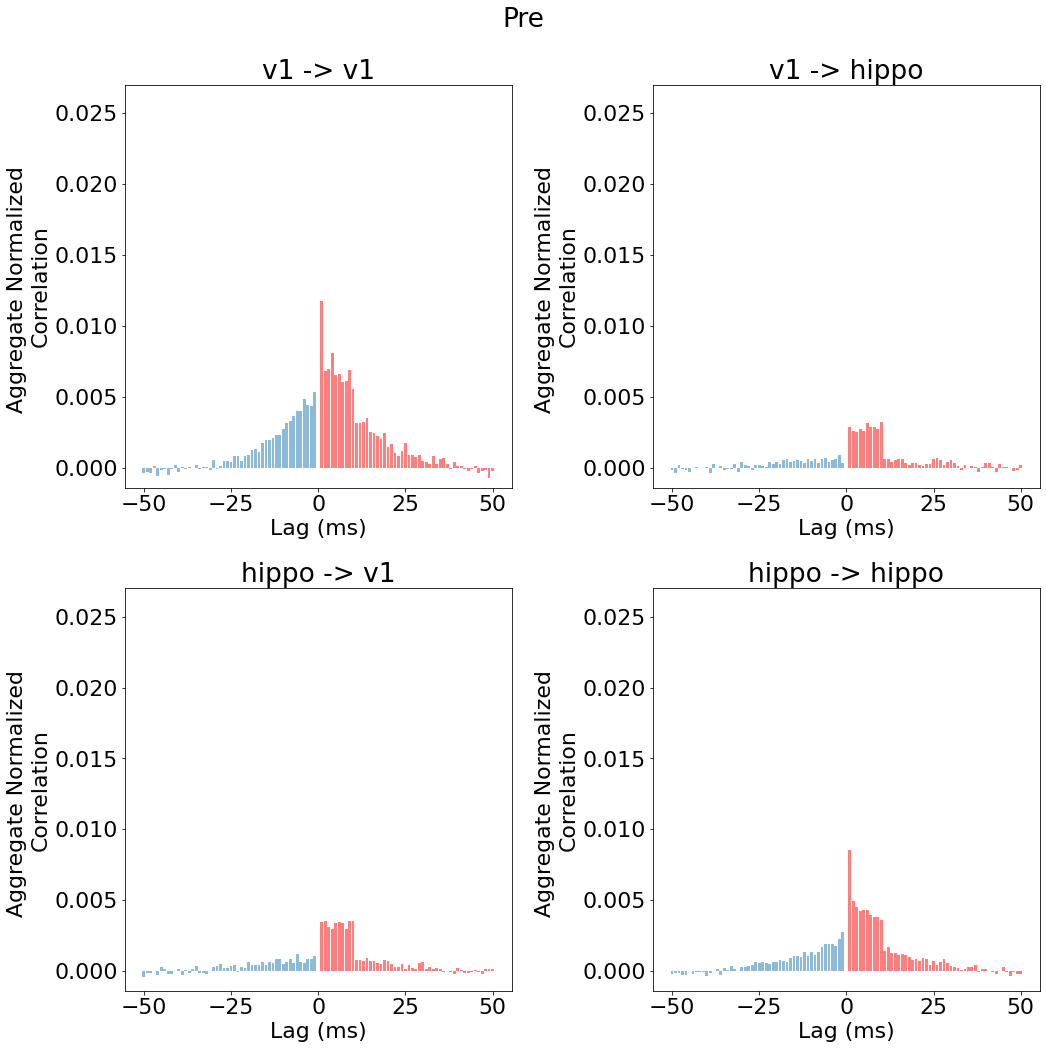

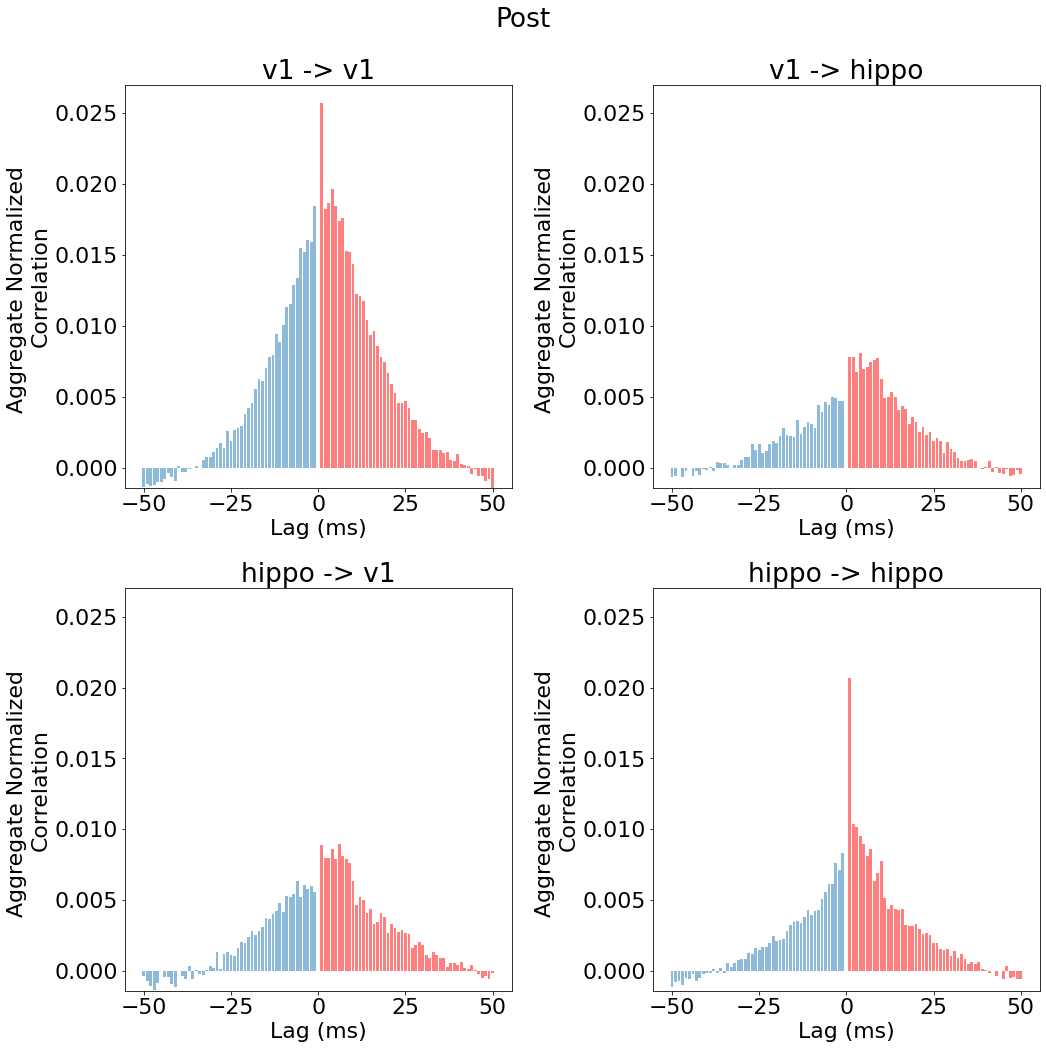

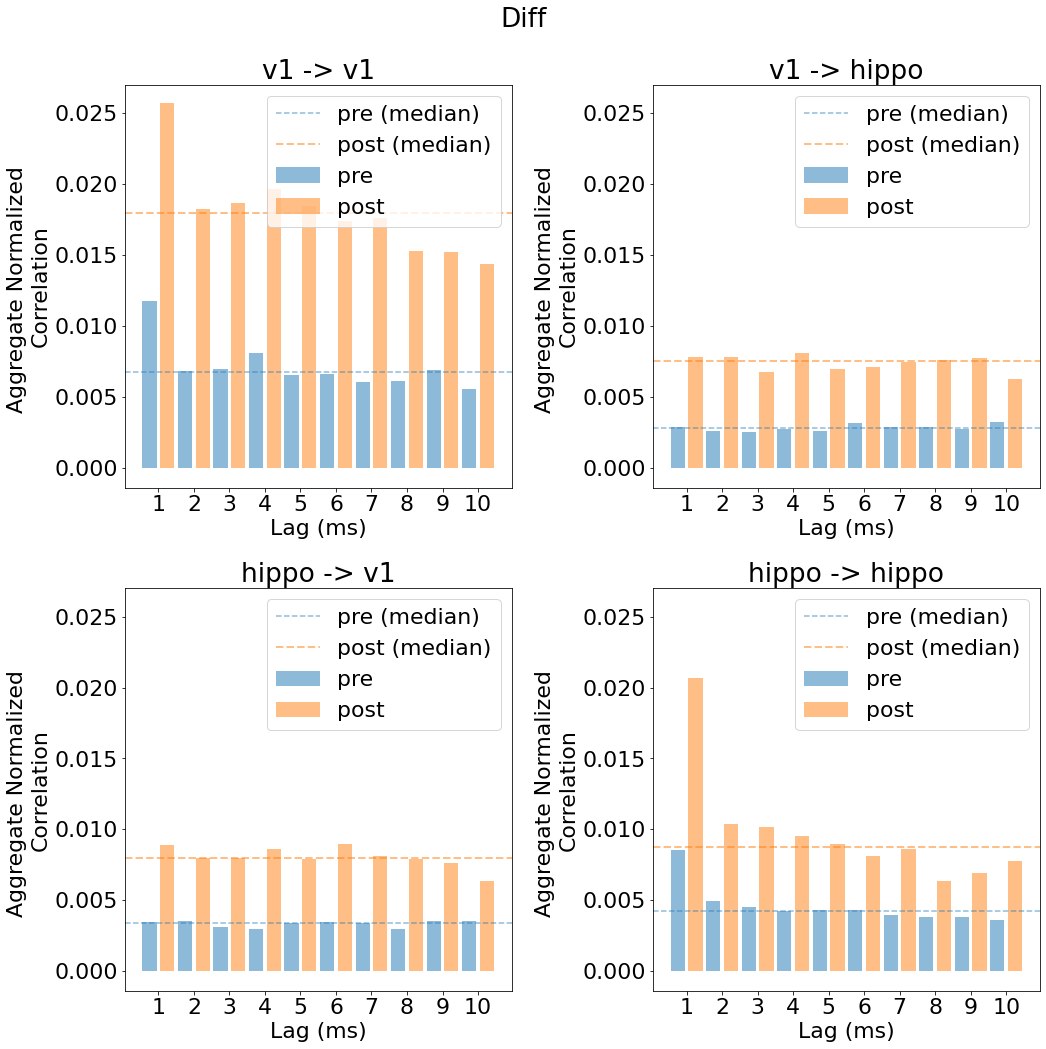

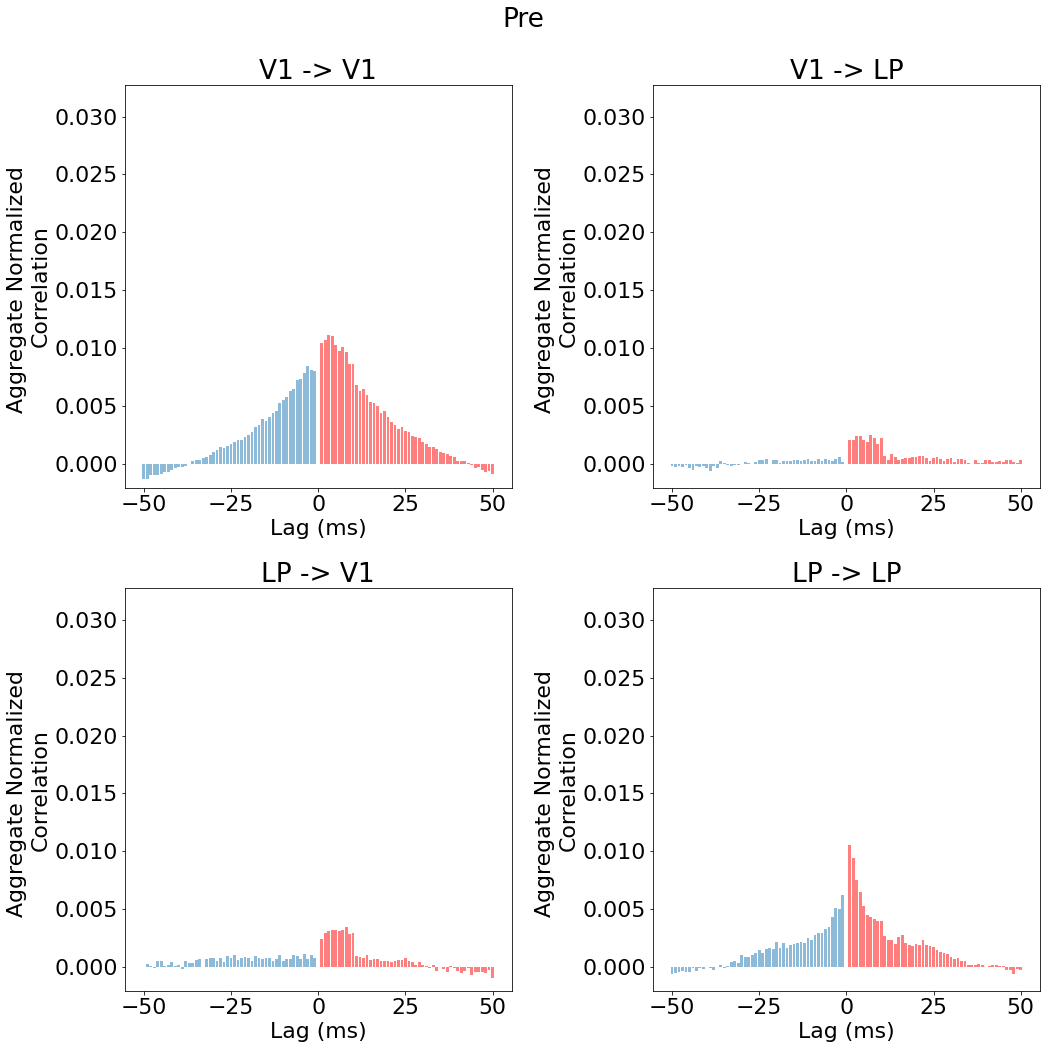

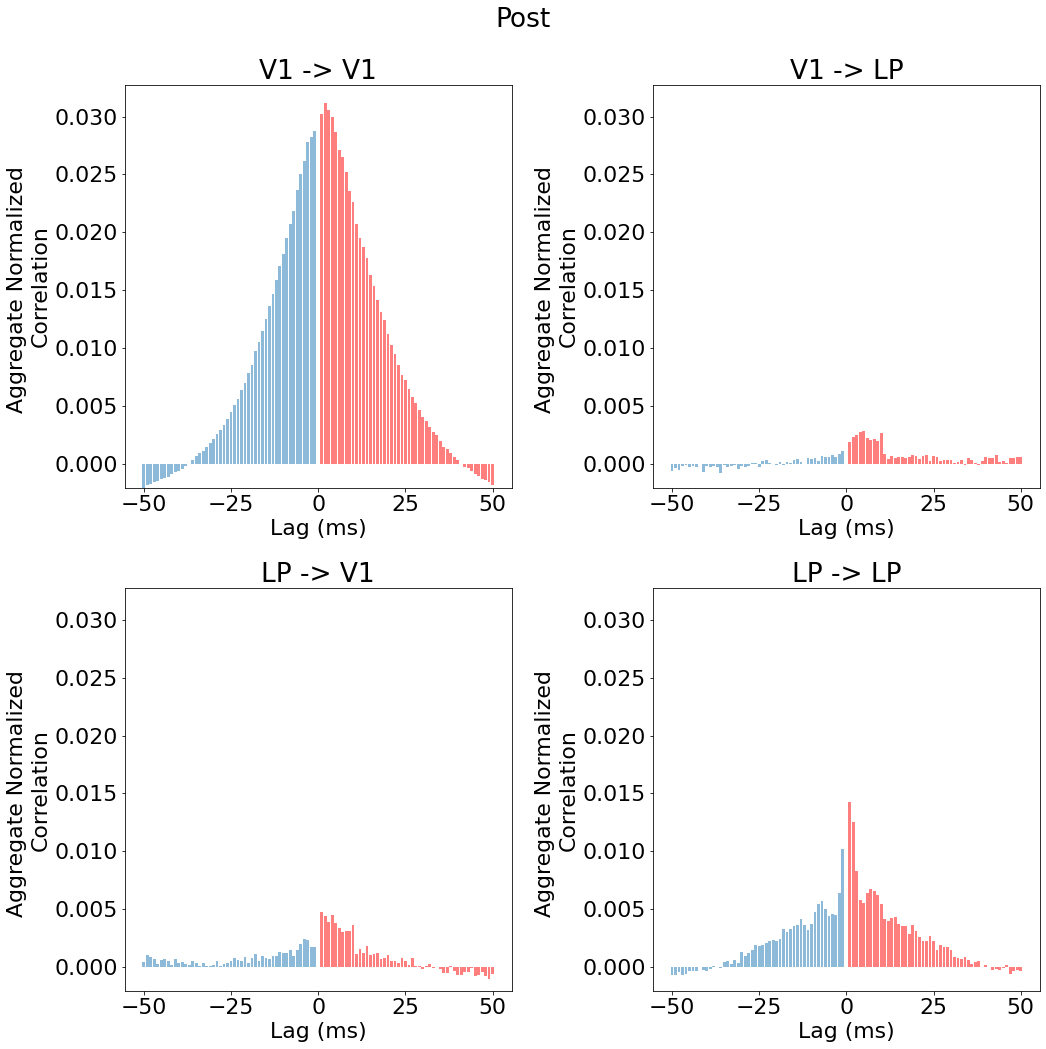

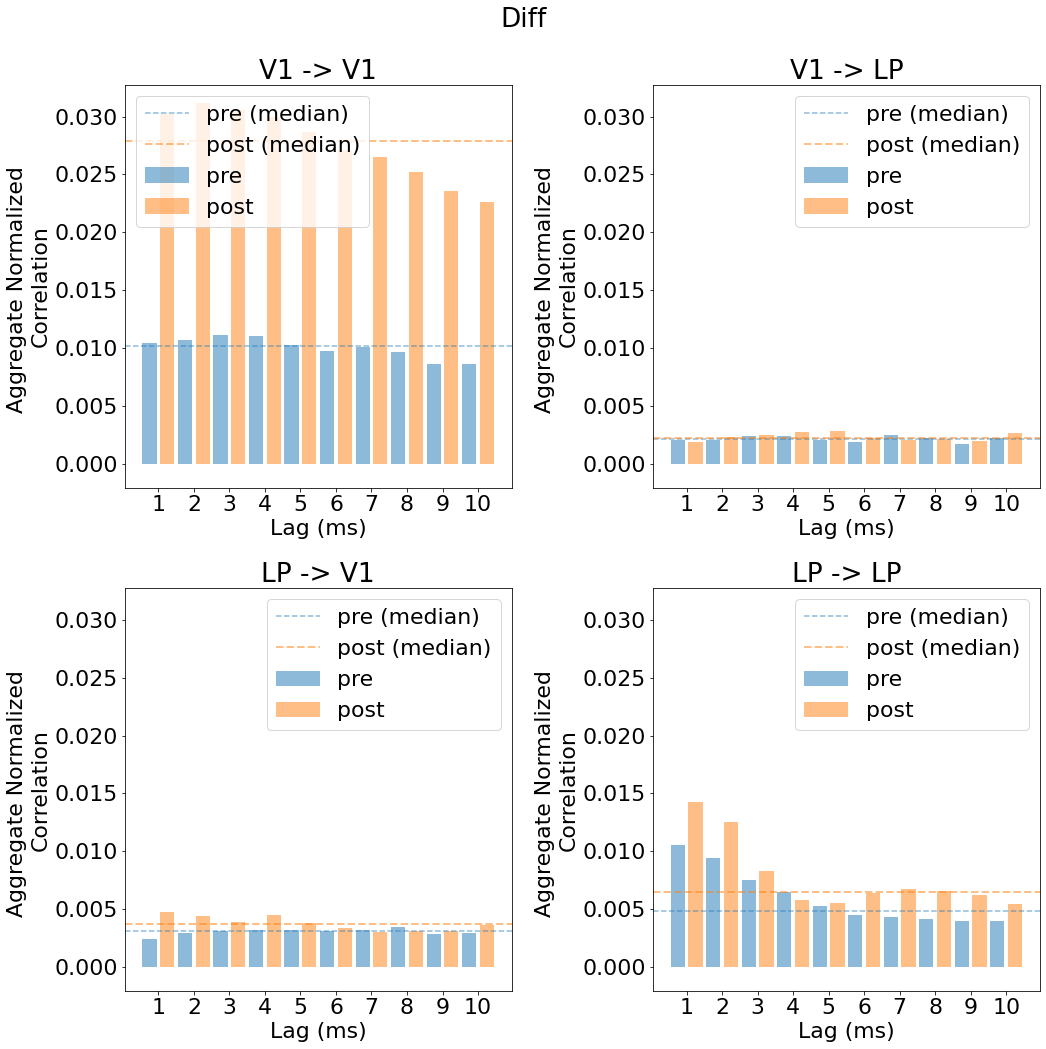

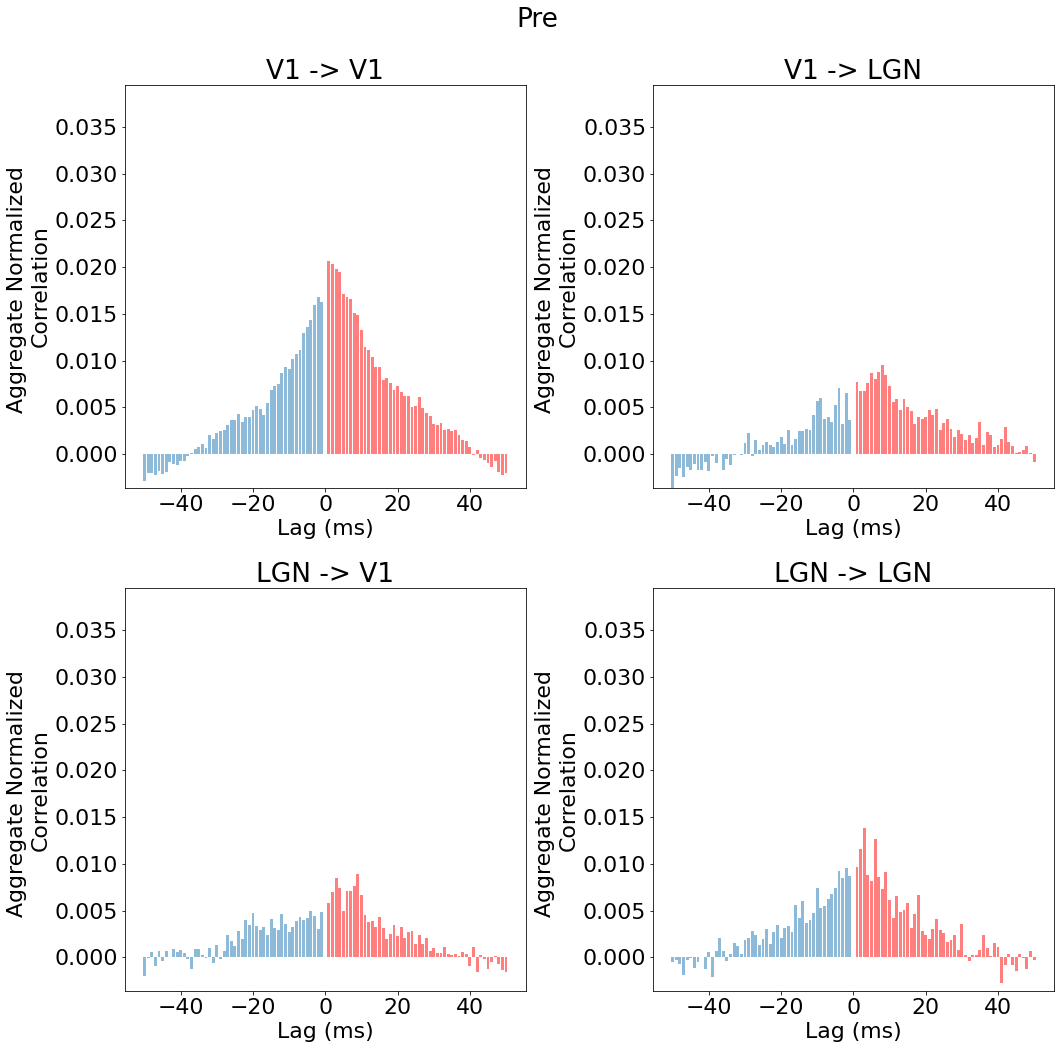

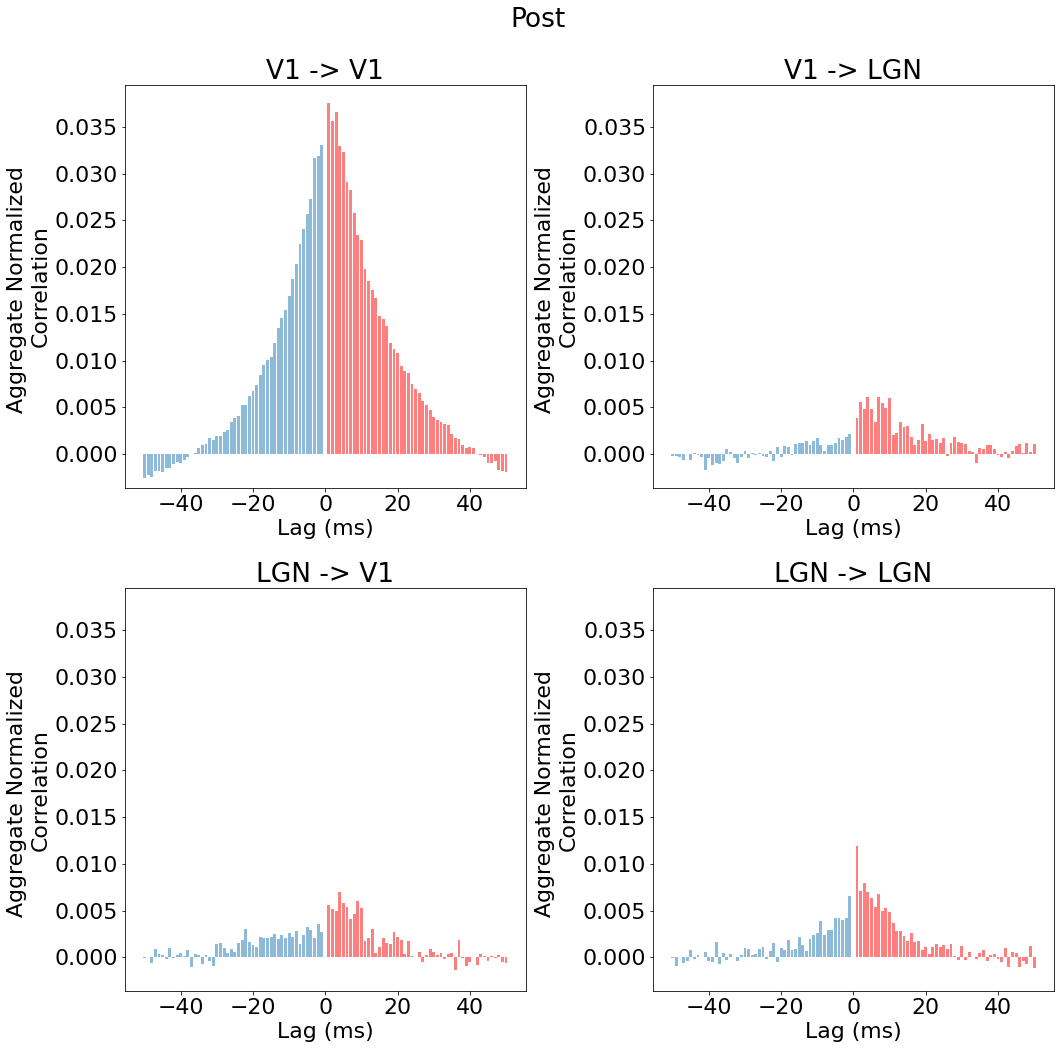

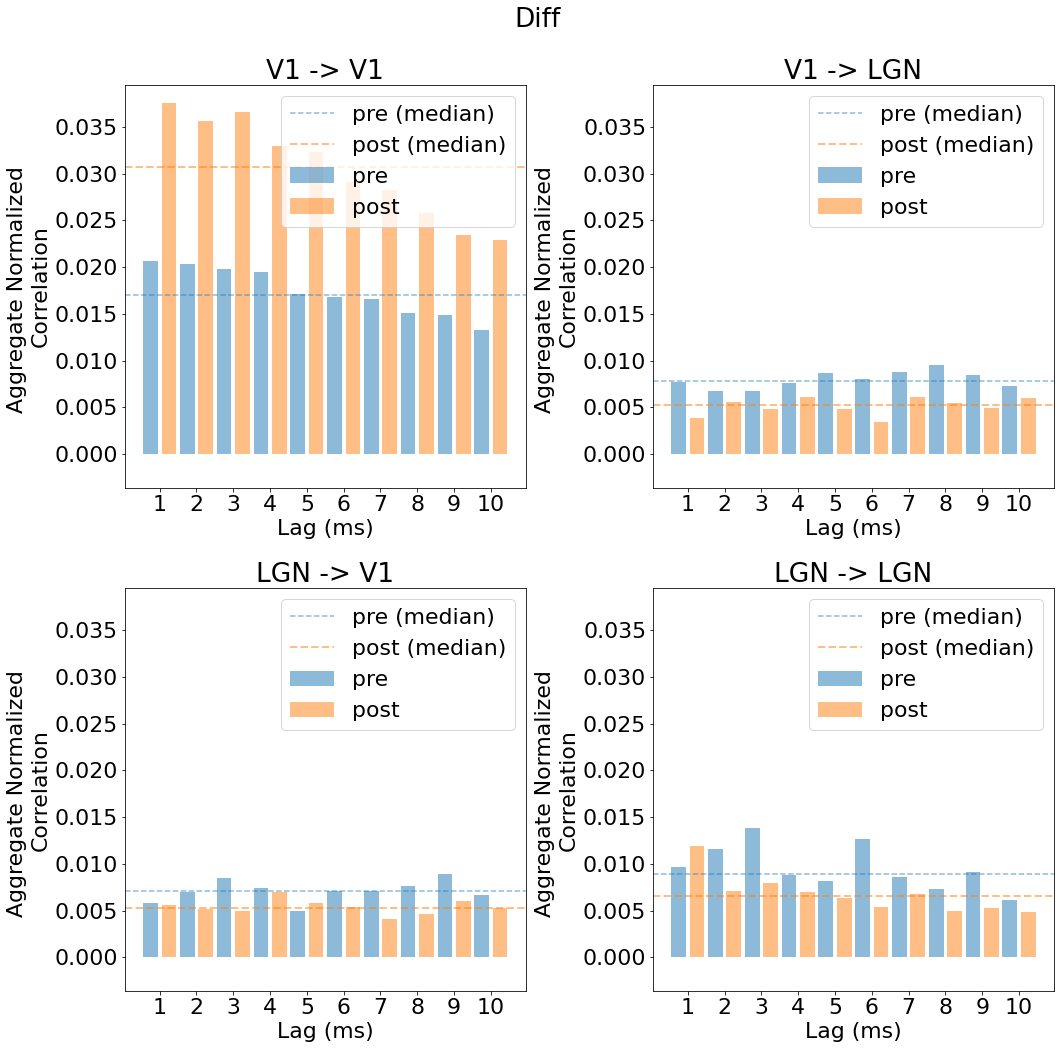

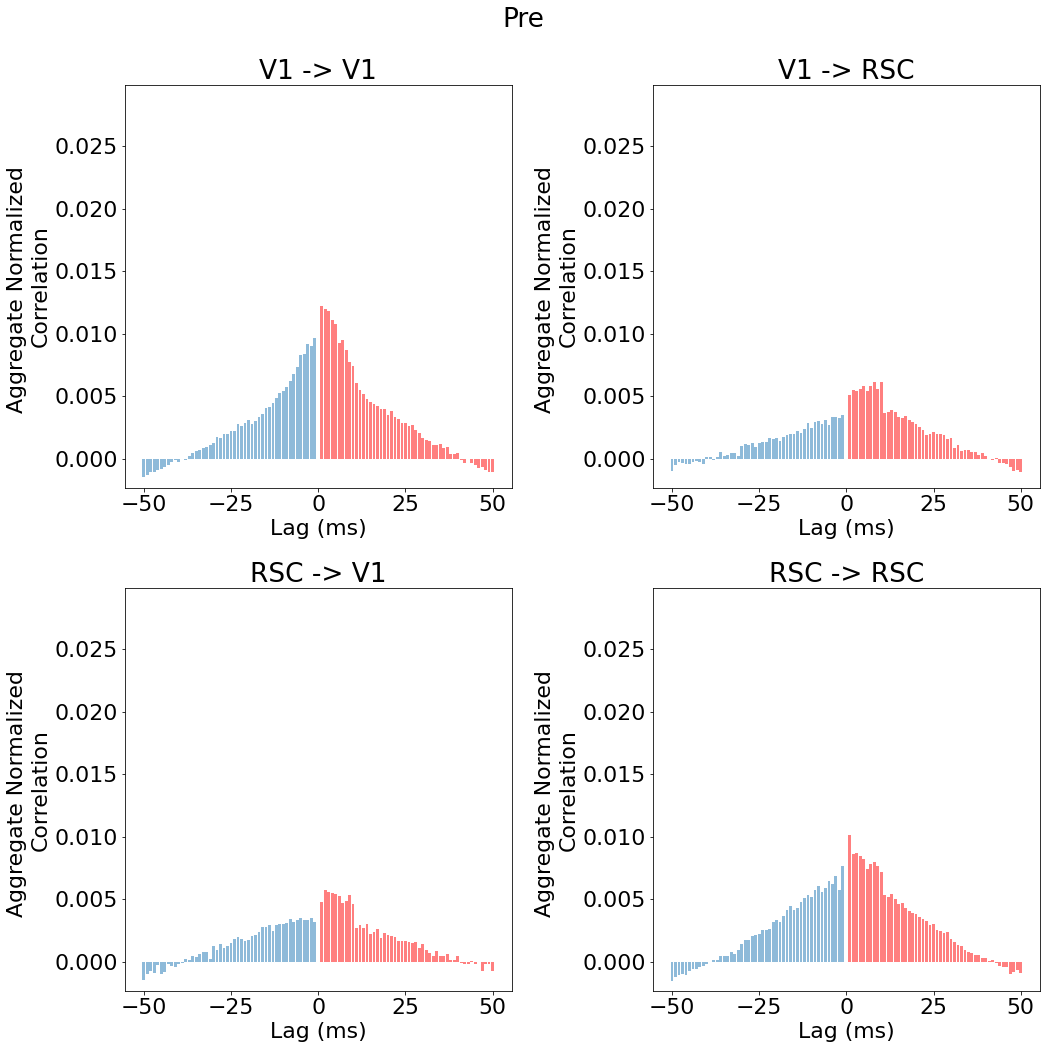

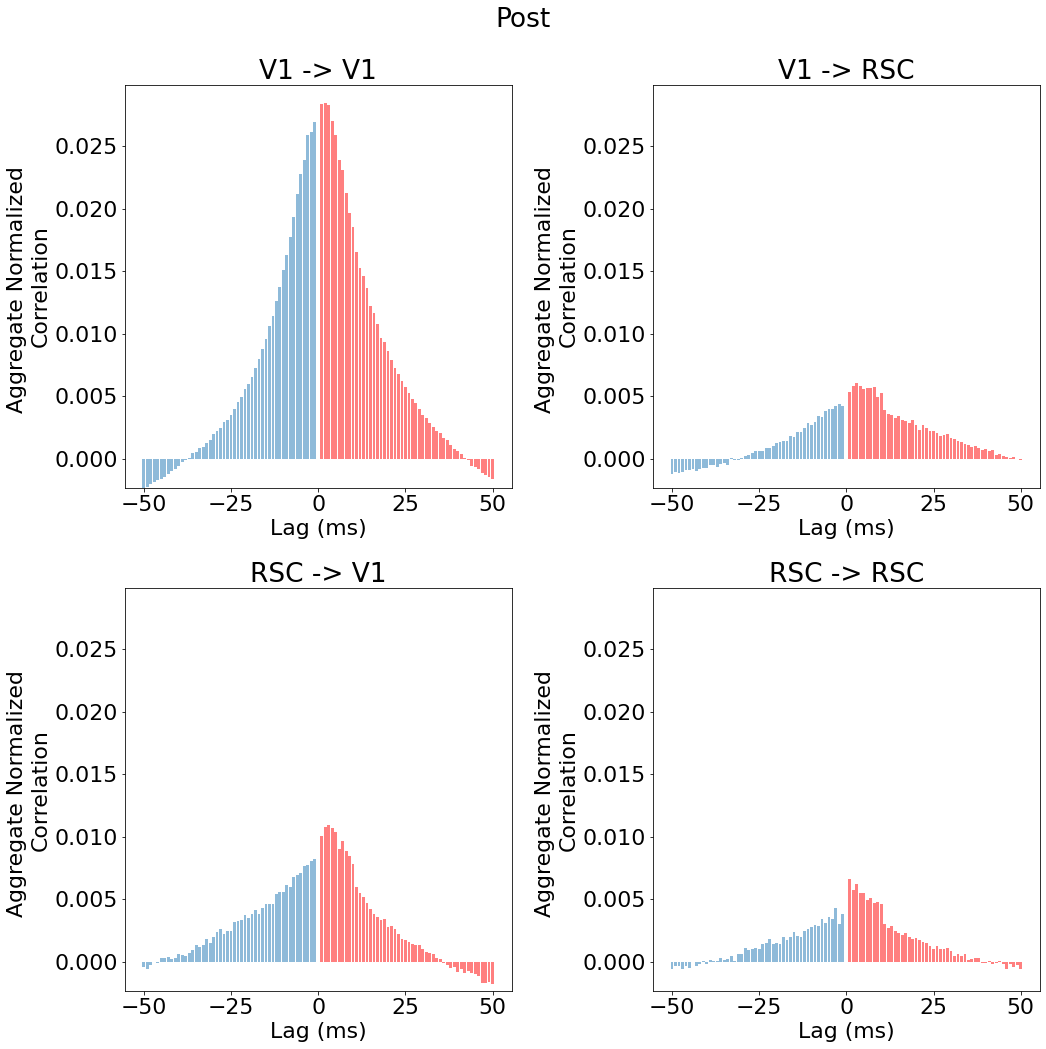

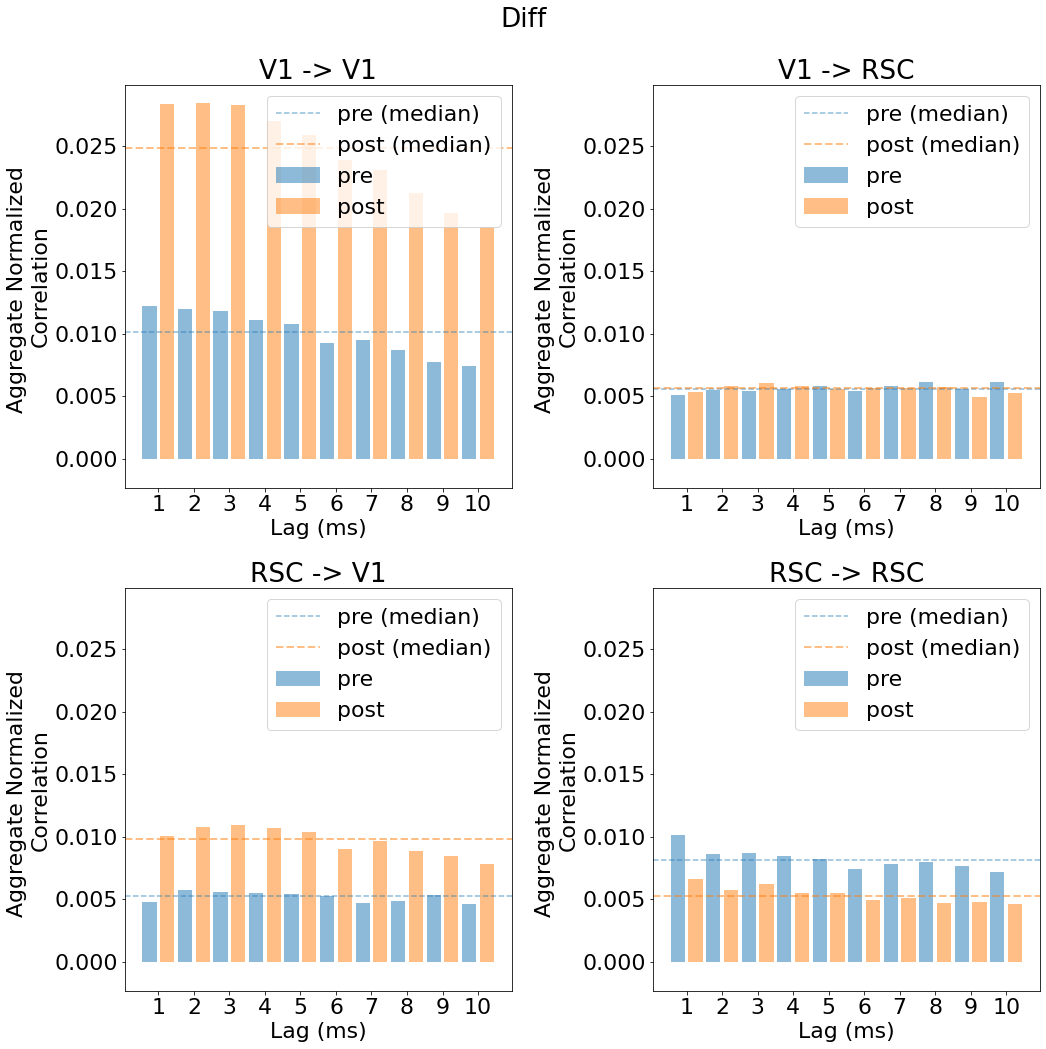

In [35]:
exps = ['pre', 'post']
filter = True # True 
print(f'Filter flag {filter}')

total_counts = {}
pairs_count_data = []
for AREAS, pre_dir, post_dir in temp:
    print(f'AREAS - {AREAS}, PRE - {pre_dir}, POST - {post_dir}')

    pre_files, post_files = [], []

    if pre_dir:
        pre_files = glob.glob(pre_dir + '../cc/*.pkl')
    if post_dir:
        post_files = glob.glob(post_dir + '../cc/*.pkl')

    # define maps 
    area_to_area = {exp: {a1: { a2: np.zeros(100) for a2 in AREAS } for a1 in AREAS} for exp in exps } 
    area_to_area_peaks = {exp: {a1: { a2: np.zeros(100) for a2 in AREAS } for a1 in AREAS} for exp in exps} 
    area_to_area_count = {exp: {a1: { a2: 0 for a2 in AREAS } for a1 in AREAS} for exp in exps} 

    total_pairs = {exp:{a1: {a2: 0 for a2 in AREAS } for a1 in AREAS } for exp in exps } 


    

    if pre_files:
        
        (area_to_area['pre'], 
            area_to_area_peaks['pre'], 
            area_to_area_count['pre'],
            total_pairs['pre'] ) = postprocess_files(
            pre_files, 
            AREAS, 
            filter=filter)
    


    if post_files:
         (area_to_area['post'], 
            area_to_area_peaks['post'], 
            area_to_area_count['post'],
            total_pairs['post']) = postprocess_files(
            post_files, 
            AREAS,
            filter=filter)
    

    max_val = 0. 
    min_val = 0.

    for a1 in AREAS:
        for a2 in AREAS:
            for exp in ['pre', 'post']:
                if area_to_area_count[exp][a1][a2]:
                    max_val = max((area_to_area[exp][a1][a2] / area_to_area_count[exp][a1][a2] ).max(), max_val )
                    min_val = min((area_to_area[exp][a1][a2] / area_to_area_count[exp][a1][a2] ).min(), min_val)
                
    max_val =  max_val * 1.05

   

    total_counts_i = {'pre': 0, 'post': 0}
    for i, a_from in enumerate(AREAS):
        for j, a_to in enumerate(AREAS):

            total_counts_i['pre'] += area_to_area_count['pre'][a_from][a_to] 
            total_counts_i['post'] += area_to_area_count['post'][a_from][a_to] 

            pairs_count_data.append([f"{a_from} -> {a_to}", 'Pre', f"{area_to_area_count['pre'][a_from][a_to]}",  f"{total_pairs['pre'][a_from][a_to]}"])
            pairs_count_data.append([f"{a_from} -> {a_to}", 'Post', f"{area_to_area_count['post'][a_from][a_to]}",  f"{total_pairs['post'][a_from][a_to]}"])
            print(f"{a_from} -> {a_to}, Pre {area_to_area_count['pre'][a_from][a_to]}, {total_pairs['pre'][a_from][a_to]}" )
            print(f"{a_from} -> {a_to}, Post {area_to_area_count['post'][a_from][a_to]}, {total_pairs['post'][a_from][a_to]}")


    total_counts[tuple(sorted(AREAS))] = total_counts_i

    # Plots for each experiment; post and pre 
    if pre_files:
        print('pre')
        plot_result(
            'Pre',
            AREAS, 
            area_to_area['pre'], 
            area_to_area_peaks['pre'], 
            area_to_area_count['pre'],
            total_pairs['pre'], min_val, max_val, None, None)
        plt.savefig(f'correlation-pre-histogram-{"_".join(AREAS)}.pdf', dpi=300)
        
    if post_files:
        print('post')
        plot_result(
            'Post',
            AREAS, 
            area_to_area['post'], 
            area_to_area_peaks['post'], 
            area_to_area_count['post'],
            total_pairs['post'], min_val, max_val, None, None)
            
        plt.savefig(f'correlation-post-histogram-{"_".join(AREAS)}.pdf', dpi=300)

    #Diff plots 
    plot_result_diff(
        AREAS, 
        area_to_area['pre'], 
        area_to_area_count['pre'],
        area_to_area['post'], 
        area_to_area_count['post'],
        min_val, 
        max_val
    )

    plt.savefig(f'correlation-diff-barchart-{"_".join(AREAS)}.pdf', dpi=300)

In [38]:
import pandas 
pandas.DataFrame(pairs_count_data, columns=['Area Pair', 'Experiment', '#Pairs', '#Total Pairs'])

,Area Pair,Experiment,#Pairs,#Total Pairs
0,v1 -> v1,Pre,1679,23771
1,v1 -> v1,Post,1235,10429
2,v1 -> hippo,Pre,2312,46435
3,v1 -> hippo,Post,940,18761
4,hippo -> v1,Pre,2347,23771
5,hippo -> v1,Post,908,10429
6,hippo -> hippo,Pre,5566,46435
7,hippo -> hippo,Post,2332,18761
8,V1 -> V1,Pre,8498,67216
9,V1 -> V1,Post,13944,36448


# pvalues shuffling unit-to-unit pairs  

In [10]:
def split(lst, prop):
    lst_1, lst_2 = [], []

    toss = np.random.binomial(1, prop, size=len(lst))
    for i in range(len(lst)):
        if toss[i] == 1:
            lst_1.append(lst[i])
        else:
            lst_2.append(lst[i])
    return lst_1, lst_2 

# split([1,2,3], 0.000), split([1,2,3], 1.000) -- test 
# TODO: make this non-random (cacheable)

@lru_cache(maxsize=2000)
def compute_extremes(f, filter=True):
    data = load_pkl_data(f)

    # filter parents with correlations exceeding
    threshold = 3 * data['correlation_adjusted'].std(-1) 

    # extremes = np.abs(data['correlation_adjusted'][:, W-10: W+10] / ( threshold[..., None] + 1e-10) ).max(-1) 
    extremes = np.abs(data['correlation_adjusted'][:, W: W+10] / ( threshold[..., None] + 1e-10) ).max(-1) 
    # units with extremes exceeding threshold 
    extremes = np.array([ e > 1. for e in extremes ]) # filter in unit if exceeds threshold 
    # extremes = np.array([ True for e in extremes ]) # every unit included 
    assert len(extremes) == len(data['unitXs'])

    if not filter:
        extremes = np.array([ True for _ in extremes ]) # select all units instead 


    return data, extremes


def post_process_file_random(f, areas, filter=True, pre_prop=None):
    """
    Process a correlation file with random pre/post assignment probability and return the aggregate quantities
    """

    data, extremes = compute_extremes(f, filter=filter)


    a2a_f = { exp: {a1: {a2: np.zeros(100) for a2 in areas } for a1 in areas } for exp in ['pre', 'post'] }
    a2a_counts_f = { exp: {a1: {a2: 0  for a2 in areas } for a1 in areas } for exp in ['pre', 'post'] }
    total_pairs_f = { exp: {a1: {a2: 0  for a2 in areas } for a1 in areas } for exp in ['pre', 'post'] }

    
    for a in areas:  # -- parent areas 
        # iterate over areas 
        # extract matching units 
        
        areaX = a # copy parent area 
        unitXs = [ i for i, u in enumerate(data['unitXs']) if f"_{areaX}_" in u  and extremes[i]]
        
        unitY = data["unitY"] # extract child unit 
        areaY = unitY.split('_')[-2]
        
        unitXs_pre, unitXs_post = split(unitXs, pre_prop)
        
        assert len(unitXs) == len(unitXs_pre) + len(unitXs_post)
        
        a2a_f['pre'][areaX][areaY] = data['correlation_adjusted'][unitXs_pre, :].sum(0)
        a2a_f['post'][areaX][areaY] = data['correlation_adjusted'][unitXs_post, :].sum(0)
        
        
        a2a_counts_f['pre'][areaX][areaY] = len(unitXs_pre)   # total number of pairs used in the analysis 
        a2a_counts_f['post'][areaX][areaY] = len(unitXs_post)
        assert a2a_counts_f['post'][areaX][areaY] + a2a_counts_f['pre'][areaX][areaY] == len(unitXs)


        # no selection on total pairs here -- does not have any meaning in this case 
        total_pairs_f['pre'][areaX][areaY] = len(data['unitXs'])
        total_pairs_f['post'][areaX][areaY] = len(data['unitXs'])
    
    return a2a_f, a2a_counts_f, total_pairs_f



def postprocess_files_random(files, areas, filter=True, pre_prop=None):
    """
    files - list of files 
    areas - areas to consider 
    filter - flag for filtering units parents whose correlation exceed the   threshold 
    """
    a2a = { exp: {a1: {a2: np.zeros(100) for a2 in areas } for a1 in areas }for exp in ['pre', 'post'] }
    a2a_counts = { exp: {a1: {a2: 0  for a2 in areas } for a1 in areas } for exp in ['pre', 'post'] }
    total_pairs = { exp: {a1: {a2: 0 for a2 in areas } for a1 in areas } for exp in ['pre', 'post'] }

    areas = tuple(areas)
    for f in files:

        a2a_f, a2a_counts_f, total_pairs_f = post_process_file_random(f, areas, filter=filter, pre_prop=pre_prop)
        
        # copy over values 
        for aX in areas:
            for aY in areas:
                for exp in ['pre', 'post']:
                    a2a[exp][aX][aY] += a2a_f[exp][aX][aY]
                    a2a_counts[exp][aX][aY] += a2a_counts_f[exp][aX][aY]
                    total_pairs[exp][aX][aY] += total_pairs_f[exp][aX][aY]
    
    return  a2a, a2a_counts, total_pairs
    

In [12]:
import tqdm 
exps = ['pre', 'post']
filter = True # True 
print(f'Filter flag {filter}')

results = []

true_diffs = []
for AREAS, pre_dir, post_dir in temp:
    print(f'AREAS - {AREAS}, PRE - {pre_dir}, POST - {post_dir}')
    # read total #pairs count 
    total_counts_i = total_counts[tuple(sorted(AREAS))]
    # pre_prop = pre_pairs / (pre_pairs + post_pairs)
    pre_prop = total_counts_i['pre'] / ( total_counts_i['pre'] +  total_counts_i['post'] )
    print(f'Pre prop {pre_prop}')

    # read list of files 
    pre_files, post_files = [], []

    if pre_dir:
        pre_files = glob.glob(pre_dir + '../cc/*.pkl')
    if post_dir:
        post_files = glob.glob(post_dir + '../cc/*.pkl')
    
    # merge all files 
    files = pre_files + post_files 

    diff = { a1: { a2: [] for a2 in AREAS} for a1 in  AREAS }


    def compute_diff(shuffled=True):
        
        # pre_files = [files[i] for i in range(len(files)) if binary[i] == 1]
        # post_files = [files[i] for i in range(len(files)) if binary[i] == 0]
        # post_files = files[pre_size:]

        # define maps 
        area_to_area = {exp: {a1: { a2: np.zeros(100) for a2 in AREAS } for a1 in AREAS} for exp in exps } 
        area_to_area_peaks = {exp: {a1: { a2: np.zeros(100) for a2 in AREAS } for a1 in AREAS} for exp in exps} 
        area_to_area_count = {exp: {a1: { a2: 0 for a2 in AREAS } for a1 in AREAS} for exp in exps} 

        total_pairs = {exp:{a1: {a2: 0 for a2 in AREAS } for a1 in AREAS } for exp in exps } 

        if not shuffled:
            # compute true difference using "pre_file" and "post_files"
            if pre_files:
                
                (area_to_area['pre'], 
                    area_to_area_peaks['pre'], 
                    area_to_area_count['pre'],
                    total_pairs['pre'] ) = postprocess_files(
                    pre_files, 
                    AREAS, 
                    filter=filter)
            
            if post_files:
                (area_to_area['post'], 
                    area_to_area_peaks['post'], 
                    area_to_area_count['post'],
                    total_pairs['post']) = postprocess_files(
                    post_files, 
                    AREAS,
                    filter=filter)

            true_diff = { a1: { a2: 0. for a2 in AREAS} for a1 in  AREAS }
            for aX in AREAS:
                for aY in AREAS:
                    true_diff[aX][aY] = (
                        np.median( 
                            area_to_area['post'][aX][aY][W:W+10] / area_to_area_count['post'][aX][aY]
                        ) - np.median(
                            area_to_area['pre'][aX][aY][W:W+10] / area_to_area_count['pre'][aX][aY])
                    )
            
            return true_diff

        else:
            a2a_random, a2a_counts_random, total_pairs_random = postprocess_files_random(
                files, 
                AREAS, 
                filter=filter, 
                pre_prop=pre_prop)


            for aX in AREAS:
                for aY in AREAS:
                    diff[aX][aY].append(
                        np.median( 
                            a2a_random['post'][aX][aY][W:W+10] / a2a_counts_random['post'][aX][aY]
                        ) 
                        - np.median(
                            a2a_random['pre'][aX][aY][W:W+10] / a2a_counts_random['pre'][aX][aY]))
            
            
        
        

    # compute diffs 
    print('done --- computing true diff now ')
    true_diff  = compute_diff(shuffled=False) 
    true_diffs.append((AREAS, true_diff))
    


    # shuffle binary and do it over and over 

    for i in tqdm.tqdm(range(100_000)):
    
        compute_diff() # computes an populate difference between them  
    

    # compute difference of true diff with randomized diff 
    pvals = { a1: { a2: (
        ( 
            np.abs(np.array(diff[a1][a2])) >= np.abs(true_diff[a1][a2])
        ).mean() # two-sided, hence absolute value  
    ) for a2 in AREAS} for a1 in  AREAS }

    results.append(pvals)



Filter flag True
AREAS - ['v1', 'hippo'], PRE - ../../V1HPC/output__stimuli_0/DI_values/V1HPC_spks_CQuinn_pre/0/500_1500/lasso_0.5/, POST - ../../V1HPC/output__stimuli_0/DI_values/V1HPC_spks_CQuinn_post/0/500_1500/lasso_0.5/
Pre prop 0.6873376060973497
done --- computing true diff now 


100%|██████████| 100000/100000 [5:14:04<00:00,  5.31it/s] 


AREAS - ['V1', 'LP'], PRE - ../../V1LP/output__stimuli_0/DI_values/V1LP_spks_CQuinn_pre/0/500_1500/lasso_0.5/, POST - ../../V1LP/output__stimuli_0/DI_values/V1LP_spks_CQuinn_post/0/500_1500/lasso_0.5/
Pre prop 0.4539351474661887
done --- computing true diff now 


100%|██████████| 100000/100000 [6:24:44<00:00,  4.33it/s] 


AREAS - ['V1', 'LGN'], PRE - ../../V1LGN/output__stimuli_0/DI_values/V1LGN_spks_CQuinn_pre/0/500_1500/lasso_0.5/, POST - ../../V1LGN/output__stimuli_0/DI_values/V1LGN_spks_CQuinn_post/0/500_1500/lasso_0.5/
Pre prop 0.29552450864314467
done --- computing true diff now 


100%|██████████| 100000/100000 [1:17:09<00:00, 21.60it/s]


AREAS - ['V1', 'RSC'], PRE - ../../V1RSC/output__stimuli_0/DI_values/V1RSC_spks_CQuinn_pre/0/500_1500/lasso_0.5/, POST - ../../V1RSC/output__stimuli_0/DI_values/V1RSC_spks_CQuinn_post/0/500_1500/lasso_0.5/
Pre prop 0.4067826831181799
done --- computing true diff now 


100%|██████████| 100000/100000 [5:25:51<00:00,  5.11it/s] 


In [394]:
results 

[{'v1': {'v1': 0.0, 'hippo': 0.0}, 'hippo': {'v1': 0.0, 'hippo': 0.0}},
 {'V1': {'V1': 0.0, 'LP': 0.319}, 'LP': {'V1': 0.0, 'LP': 0.0}},
 {'V1': {'V1': 0.0, 'LGN': 0.0}, 'LGN': {'V1': 0.028, 'LGN': 0.016}},
 {'V1': {'V1': 0.0, 'RSC': 0.853}, 'RSC': {'V1': 0.0, 'RSC': 0.0}}]

In [16]:
print('Before correction ')
for r in results:
    for k1 in r.keys():
        for k2 in r[k1].keys():
            print(k1, k2, r[k1][k2], r[k1][k2] < 0.05) 

Before correction 
v1 v1 0.0 True
v1 hippo 0.0 True
hippo v1 0.0 True
hippo hippo 0.0 True
V1 V1 0.0 True
V1 LP 0.33444 False
LP V1 0.0001 True
LP LP 0.0 True
V1 V1 0.0 True
V1 LGN 0.00012 True
LGN V1 0.03223 True
LGN LGN 0.01387 True
V1 V1 0.0 True
V1 RSC 0.85597 False
RSC V1 0.0 True
RSC RSC 0.0 True


In [36]:
true_diffs

[(['v1', 'hippo'],
  {'v1': {'v1': 0.011215762925056254, 'hippo': 0.004748467693582181},
   'hippo': {'v1': 0.004579090293739786, 'hippo': 0.004494995219310535}}),
 (['V1', 'LP'],
  {'V1': {'V1': 0.017716206539044217, 'LP': 0.00011931194968439534},
   'LP': {'V1': 0.0006518661172047434, 'LP': 0.0016106214171034876}}),
 (['V1', 'LGN'],
  {'V1': {'V1': 0.013726338123123304, 'LGN': -0.0026190933172008475},
   'LGN': {'V1': -0.0018049120104139142, 'LGN': -0.00238232554660175}}),
 (['V1', 'RSC'],
  {'V1': {'V1': 0.014755181244922644, 'RSC': 3.8919992225907446e-05},
   'RSC': {'V1': 0.004555064184264247, 'RSC': -0.0028586689520912556}})]

In [18]:
raw_results = results 

hippo -> hippo 0.0 True
hippo -> v1 0.0 True
v1 -> hippo 0.0 True
v1 -> v1 0.0 True
LP -> LP 0.0 True
LP -> V1 0.00013333333333333334 True
V1 -> LP 0.33444 False
V1 -> V1 0.0 True
LGN -> LGN 0.018493333333333334 True
LGN -> V1 0.03223 True
V1 -> LGN 0.00024 True
V1 -> V1 0.0 True
RSC -> RSC 0.0 True
RSC -> V1 0.0 True
V1 -> RSC 0.85597 False
V1 -> V1 0.0 True


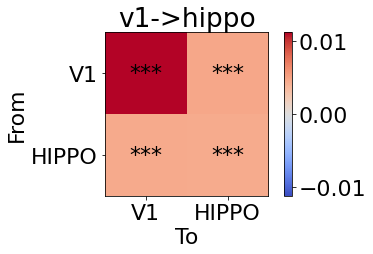

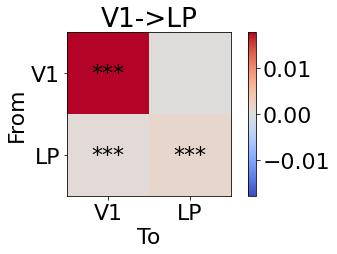

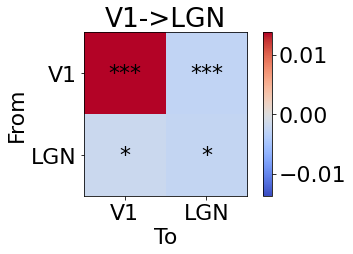

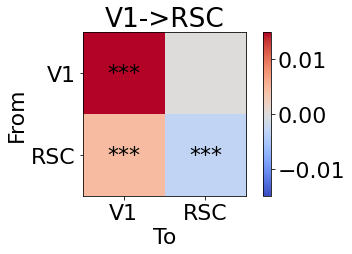

In [25]:


from statsmodels.stats.multitest import multipletests as mt 

for r, td in zip(results, true_diffs):
    
    areas = sorted(r.keys())
    pvals = np.ones( ( len(areas), len(areas), ) ) * np.nan 
    corrected = {a1: { a2: np.nan for a2 in areas } for a1 in areas }
    for i, groupX in enumerate(areas):
        for j, groupY in enumerate(areas):
            pvals[i][j] = r[groupX][groupY]


    pvals = mt(pvals.reshape(-1), method='fdr_bh')[1]
    pvals = pvals.reshape(len(areas), len(areas))

    
    for i, groupX in enumerate(areas):
        for j, groupY in enumerate(areas):
            corrected[groupX][groupY] = pvals[i][j]

    for k, v in corrected.items():
        for k2, v2 in v.items():
            print(f'{k} -> {k2} {v2} {v2 < 0.05}')



    # plot with p-values 

    areas = td[0]
    heatmap= np.zeros( ( len(areas), len(areas)))
    heatmap_pvals = np.zeros( ( len(areas), len(areas)))
    for i, groupX in enumerate(areas):
        for j, groupY in enumerate(areas):
            heatmap[i][j] = td[1][groupX][groupY]
            heatmap_pvals[i][j] = corrected[groupX][groupY]

 
    plt.figure()
    max_ = np.max(np.abs(heatmap))
    plt.imshow(heatmap, interpolation='nearest',
                cmap=plt.cm.coolwarm,
                vmin=-max_, 
                vmax=max_)
    plt.title('->'.join(areas))
    plt.xticks(np.arange(len(areas)), labels=[ a.upper() for a in areas])
    plt.xlabel('To')
    plt.ylabel('From')
    plt.yticks(np.arange(len(areas)), labels=[ a.upper() for a in areas])
    plt.colorbar()

    for i  in range(heatmap_pvals.shape[0]):
        for j in range(heatmap_pvals.shape[1]):
            if np.isnan(heatmap_pvals[(i, j)]):
                plt.text(j, i, 'nan', ha="center", va="center", color="black")
            elif heatmap_pvals[(i,j)] < 0.001:
                plt.text(j, i, '***', ha="center", va="center", color="black")
            elif heatmap_pvals[(i,j)] < 0.01:
                plt.text(j, i, '**', ha="center", va="center", color="black")
            elif heatmap_pvals[(i,j)] < 0.05:
                plt.text(j, i, '*', ha="center", va="center", color="black")

    plt.tight_layout()
    plt.savefig(f'correlation-diff-output_{"-".join(areas)}.pdf', dpi=300)